### Comparing the network with state-of-the-art networks

#### 1.Import Libraries

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split


#### 2: Define Paths and Split Ratios

In [7]:
# Paths to the dataset and output folder
data_dir = r"C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste"
output_dir = r"C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


#### 3: Helper Function to Create Directories

In [8]:
# Function to create a directory if it doesn't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


#### 4: Prepare Output Directories

In [9]:
# Define output folders for train, val, and test
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

# Create output directories
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)


#### 5:Split Dataset into Train, Validation, and Test Sets

In [10]:
# Iterate through each class folder in the dataset
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    
    # Ensure only directories are processed
    if not os.path.isdir(class_path):
        continue

    # Get all images in the class folder
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('jpg', 'png', 'jpeg'))]

    # Split data into train, val, and test
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Create subdirectories for each subset
    for subset, subset_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        create_dir(subset_class_dir)

        # Copy images to the subset folder
        for img_path in subset_imgs:
            shutil.copy(img_path, subset_class_dir)


In [11]:
print(f"Dataset successfully split and saved to: {output_dir}")
print(f"Training data directory: {train_dir}")
print(f"Validation data directory: {val_dir}")
print(f"Testing data directory: {test_dir}")


Dataset successfully split and saved to: C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split
Training data directory: C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\train
Validation data directory: C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\val
Testing data directory: C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\test


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os


#### 6. Data Preprocessing

In [13]:
# Paths to dataset splits
train_dir = r"C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\train"
val_dir = r"C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\val"
test_dir = r"C:\Users\prave\OneDrive\Documents\GitHub\EN3150_Assignment_03_CNN-1\RealWaste_Split\test"

# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Image data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')


Found 3320 images belonging to 9 classes.
Found 713 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


##### 7. Fine-Tuning ResNet50

In [14]:
# Load ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(train_data.class_indices), activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Freeze the base layers of ResNet50
for layer in resnet_base.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(train_data, validation_data=val_data, epochs=10)

# Unfreeze some layers for fine-tuning
for layer in resnet_base.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet_ft = resnet_model.fit(train_data, validation_data=val_data, epochs=10)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step


c:\Users\prave\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.1688 - loss: 2.2568 - val_accuracy: 0.2553 - val_loss: 2.1016
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2239 - loss: 2.1178 - val_accuracy: 0.2553 - val_loss: 2.0665
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.2340 - loss: 2.0825 - val_accuracy: 0.2875 - val_loss: 2.0330
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1559s 15s/step - accuracy: 0.2489 - loss: 2.0557 - val_accuracy: 0.2847 - val_loss: 1.9821
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.2620 - loss: 2.0272 - val_accuracy: 0.3184 - val_loss: 1.9586
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.2598 - loss: 2.0152 - val_accuracy: 0.3198 - val_loss: 1.9297
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.2738 - loss: 2.0002 - val_accuracy: 0.3226 - val_loss: 1.9308
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2662 - loss: 1.9899 - val_ac

#### 8. Fine tuning VGG 16

In [15]:
# Load VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(train_data.class_indices), activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=output)

# Freeze the base layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg = vgg_model.fit(train_data, validation_data=val_data, epochs=10)

# Unfreeze some layers for fine-tuning
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg_ft = vgg_model.fit(train_data, validation_data=val_data, epochs=10)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1006s 10s/step - accuracy: 0.2344 - loss: 2.3708 - val_accuracy: 0.4320 - val_loss: 1.5068
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 774s 7s/step - accuracy: 0.3511 - loss: 1.6308 - val_accuracy: 0.5021 - val_loss: 1.3607
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.3869 - loss: 1.5047 - val_accuracy: 0.5372 - val_loss: 1.3452
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 589s 6s/step - accuracy: 0.3736 - loss: 1.5028 - val_accuracy: 0.5722 - val_loss: 1.2472
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3798s 37s/step - accuracy: 0.4215 - loss: 1.4176 - val_accuracy: 0.5975 - val_loss: 1.1861
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.4154 - loss: 1.3937 - val_accuracy: 0.5863 - val_loss: 1.2978
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.4106 - loss: 1.4258 - val_accuracy: 0.6424 - val_loss: 1.0656
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4

In [16]:
# Evaluate ResNet50
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_data)
print(f"ResNet50 Test Accuracy: {resnet_test_acc:.4f}")

# Evaluate VGG16
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_data)
print(f"VGG16 Test Accuracy: {vgg_test_acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3555 - loss: 1.7561
ResNet50 Test Accuracy: 0.3713
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.7646 - loss: 0.8457
VGG16 Test Accuracy: 0.7705


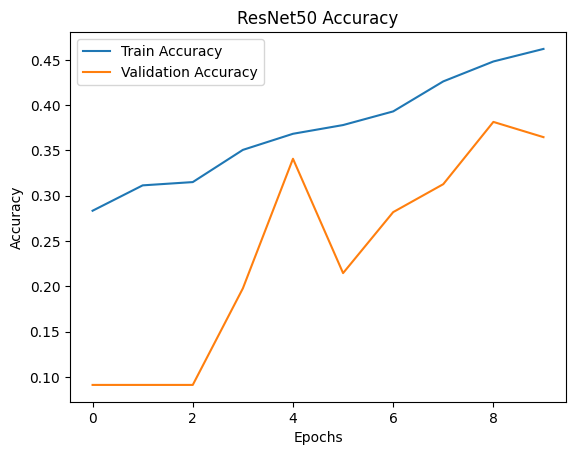

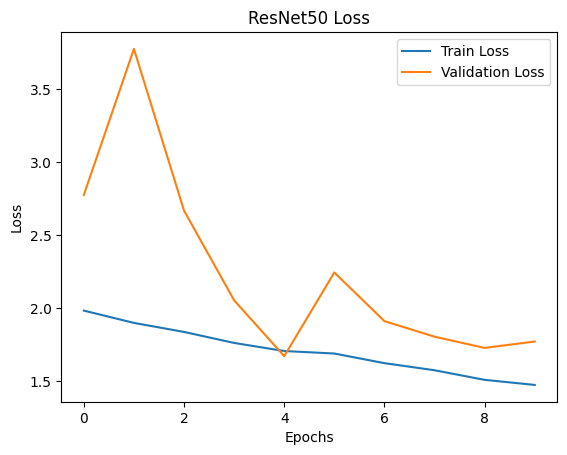

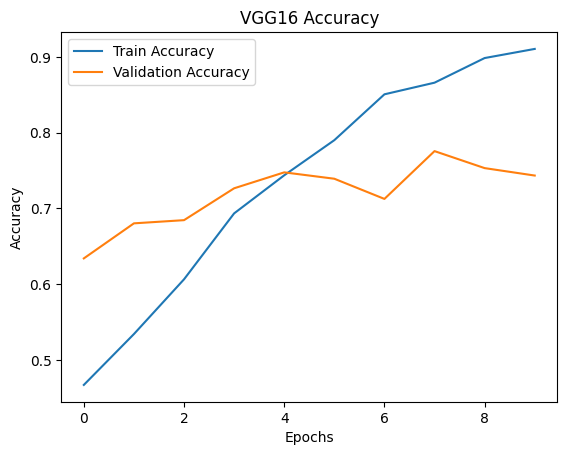

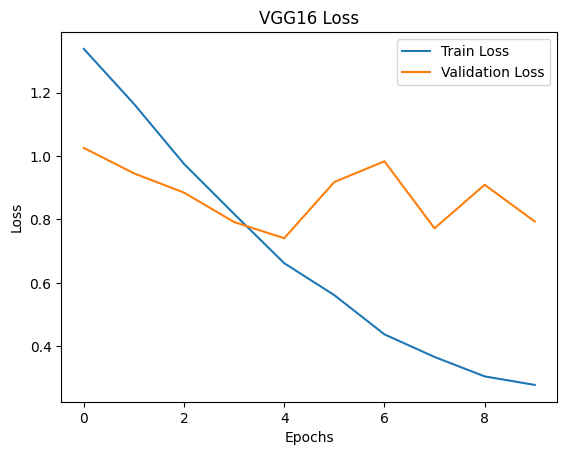

In [17]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_resnet_ft, "ResNet50")
plot_history(history_vgg_ft, "VGG16")
